In [21]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import os, torch
import torch.nn as nn
from torch import optim
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#read data
data_path = r'data/DATA.csv'
data = pd.read_csv(data_path, header=0, index_col=False)

In [22]:
#show data columns
print(data.columns)

Index(['Ref. Publication date [year:mm:dd]', 'Substrate', 'Electrode',
       'TL1-front', 'TL2-front', 'TL3-front', 'Material', 'TL4-back',
       'TL5-back', 'TL6-back', 'TL7-back', 'Electrode2',
       'Cell. Area. Measured [cm^2]', 'Cell. Architecture [nip/pin/ ?',
       'Module [TRUE/FALSE]', 'Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV]',
       'Stability. (H)'],
      dtype='object')


In [23]:
#check unique values occurances in each column
for col in data.columns:
    print(f'{col} has {len(data[col].unique())} unique values')

Ref. Publication date [year:mm:dd] has 857 unique values
Substrate has 5 unique values
Electrode has 9 unique values
TL1-front has 93 unique values
TL2-front has 60 unique values
TL3-front has 38 unique values
Material has 1 unique values
TL4-back has 260 unique values
TL5-back has 60 unique values
TL6-back has 13 unique values
TL7-back has 3 unique values
Electrode2 has 20 unique values
Cell. Area. Measured [cm^2] has 137 unique values
Cell. Architecture [nip/pin/ ? has 4 unique values
Module [TRUE/FALSE] has 2 unique values
Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV] has 105 unique values
Stability. (H) has 860 unique values


In [24]:
#check columns data type to distinguish numercial data from categorical ones
for col in data.columns:
    print(f'the {col} is of {data[col].dtype.name} data type')

the Ref. Publication date [year:mm:dd] is of object data type
the Substrate is of object data type
the Electrode is of object data type
the TL1-front is of object data type
the TL2-front is of object data type
the TL3-front is of object data type
the Material is of object data type
the TL4-back is of object data type
the TL5-back is of object data type
the TL6-back is of object data type
the TL7-back is of object data type
the Electrode2 is of object data type
the Cell. Area. Measured [cm^2] is of float64 data type
the Cell. Architecture [nip/pin/ ? is of object data type
the Module [TRUE/FALSE] is of bool data type
the Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV] is of float64 data type
the Stability. (H) is of float64 data type


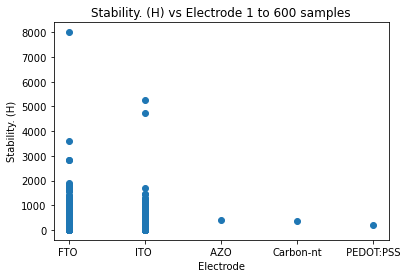

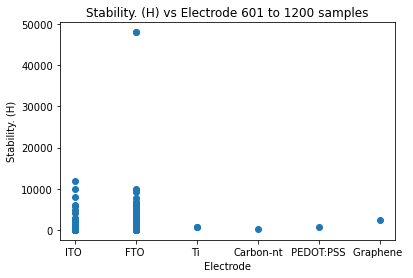

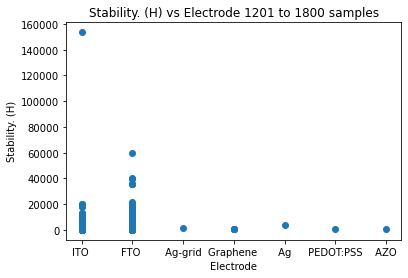

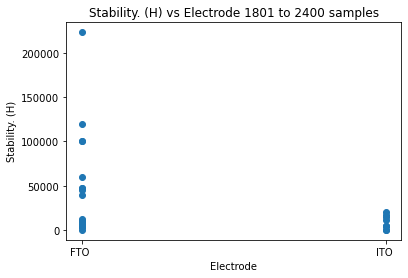

In [25]:
#visualize some categorical data
batch = 600
for idx in range(0, len(data['Electrode']), batch):
    plt.scatter(x=data['Electrode'][idx:idx+batch], y=data['Stability. (H)'][idx:idx+batch])
    plt.xlabel('Electrode')
    plt.ylabel('Stability. (H)')
    plt.title(f'Stability. (H) vs Electrode {idx+1} to {idx+batch} samples')
    plt.show()

In [26]:
#select all object, boolean and category type columns and frop Ref. Publication date [year:mm:dd] column
data_categorical = data.select_dtypes(['object', 'bool', 'category']).drop(['Ref. Publication date [year:mm:dd]'], axis=1)
data_categorical.head()


,Substrate,Electrode,TL1-front,TL2-front,TL3-front,Material,TL4-back,TL5-back,TL6-back,TL7-back,Electrode2,Cell. Architecture [nip/pin/ ?,Module [TRUE/FALSE]
0,SLG,FTO,"NiO; NiO-(c, nanowalls)",Blank,Blank,Perovskite,PCBM-60; PCBM-70,BCP,Blank,Blank,Ag,pin,False
1,SLG,ITO,Graphene oxide,Blank,Blank,Perovskite,PCBM-60; PCBM-70,BCP,Blank,Blank,Ag,pin,False
2,SLG,ITO,PEDOT:PSS,Blank,Blank,Perovskite,PCBM-60; PCBM-70,BCP,Blank,Blank,Ag,pin,False
3,SLG,ITO,PEDOT:PSS,Blank,Blank,Perovskite,PCBM-60; PCBM-70,BCP,Blank,Blank,Ag,pin,False
4,SLG,ITO,PEDOT:PSS,Blank,Blank,Perovskite,PCBM-60; PCBM-70,Blank,Blank,Blank,Ag,pin,False


In [27]:
#drop columns with lots of missing or irrelevant data
valid_categorical_col = data_categorical.drop(['TL1-front', 'TL2-front', 'TL3-front', 'TL4-back', 'TL5-back', 'TL6-back', 'TL7-back'], axis=1).columns
valid_numerical_col = data.select_dtypes('float64').columns

#visualize and check if 'blank' still exits in any column
for cat_col, num_col in zip(valid_categorical_col, valid_numerical_col):
    print(f'{cat_col}: \n{data[cat_col].value_counts()}\n____________________________________')
    print(f'{num_col}: \n{data[num_col].value_counts()}\n____________________________________\n\n\n\n\n')

Substrate: 
SLG                         1795
PET                           16
PEN                           12
PES                            2
Polyester-satin textile        1
Name: Substrate, dtype: int64
____________________________________
Cell. Area. Measured [cm^2]: 
0.1000    555
0.0900    311
0.1600    145
0.0600     64
0.0400     62
         ... 
2.0600      1
0.0875      1
2.8000      1
0.4900      1
0.0140      1
Name: Cell. Area. Measured [cm^2], Length: 137, dtype: int64
____________________________________





Electrode: 
FTO            1164
ITO             646
Graphene          5
 PEDOT:PSS        3
 AZO              2
Ti                2
Carbon-nt         2
 Ag               1
 Ag-grid          1
Name: Electrode, dtype: int64
____________________________________
Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV]: 
1.600    1126
1.500      67
1.550      67
1.590      54
1.570      36
         ... 
2.200       1
2.260       1
1.633       1
1.770       1
2.380       1
Name: Pe

In [28]:
#create new dataframe with relevant data
data_df = pd.DataFrame()
for cat_col in valid_categorical_col:
    data_df[cat_col] = data[cat_col]

for num_col in valid_numerical_col:
    data_df[num_col] = data[num_col]
data_df.head()

,Substrate,Electrode,Material,Electrode2,Cell. Architecture [nip/pin/ ?,Module [TRUE/FALSE],Cell. Area. Measured [cm^2],Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV],Stability. (H)
0,SLG,FTO,Perovskite,Ag,pin,False,0.0900,1.55,168.304498
1,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,139.363154
2,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,140.048309
3,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,140.055821
4,SLG,ITO,Perovskite,Ag,pin,False,0.0919,1.27,2.500000


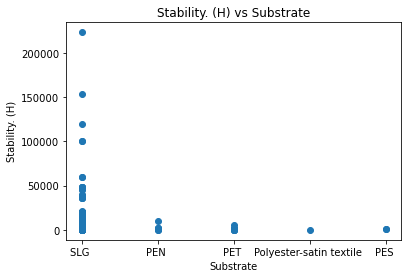

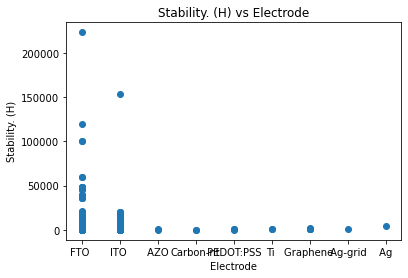

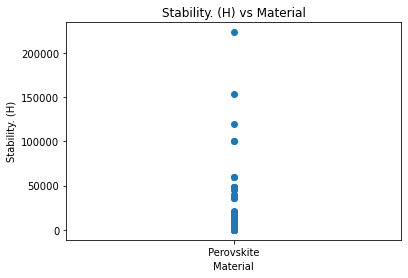

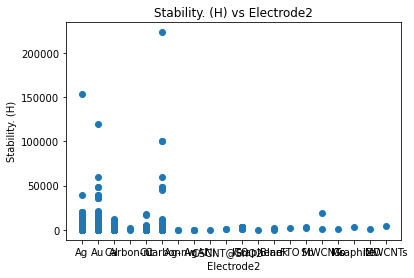

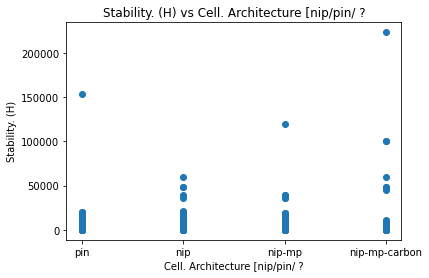

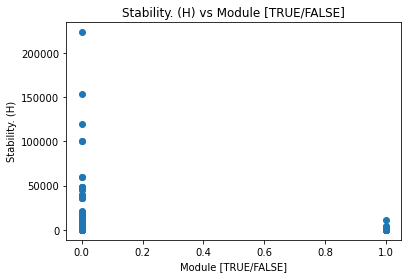

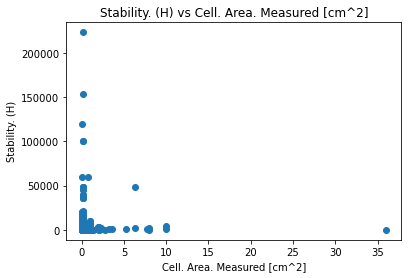

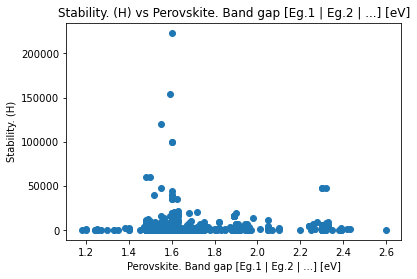

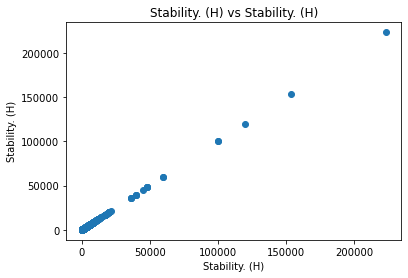

In [29]:
#plot all Stability. (H) against all features
for col in data_df.columns:
    plt.scatter(x=data_df[col], y=data_df['Stability. (H)'])
    plt.xlabel(f'{col}')
    plt.ylabel('Stability. (H)')
    plt.title(f'Stability. (H) vs {col}')
    plt.show()

In [30]:
#linear correlation analysis
data_df[valid_numerical_col].corr()

,Cell. Area. Measured [cm^2],Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV],Stability. (H)
Cell. Area. Measured [cm^2],1.000000,-0.002047,0.008450
Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV],-0.002047,1.000000,0.068629
Stability. (H),0.008450,0.068629,1.000000


In [31]:
#encode categorical features
label_enc = LabelEncoder()
for col in valid_categorical_col:
    data_df[f'{col} Encode'] = label_enc.fit_transform(data_df[col]).reshape(-1)
data_df.head(100)


,Substrate,Electrode,Material,Electrode2,Cell. Architecture [nip/pin/ ?,Module [TRUE/FALSE],Cell. Area. Measured [cm^2],Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV],Stability. (H),Substrate Encode,Electrode Encode,Material Encode,Electrode2 Encode,Cell. Architecture [nip/pin/ ? Encode,Module [TRUE/FALSE] Encode
0,SLG,FTO,Perovskite,Ag,pin,False,0.0900,1.55,168.304498,4,5,0,8,3,0
1,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,139.363154,4,7,0,8,3,0
2,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,140.048309,4,7,0,8,3,0
3,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,140.055821,4,7,0,8,3,0
4,SLG,ITO,Perovskite,Ag,pin,False,0.0919,1.27,2.500000,4,7,0,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SLG,FTO,Perovskite,Au,nip,False,0.0810,1.60,64.000000,4,5,0,10,0,0
96,SLG,ITO,Perovskite,Al,pin,False,0.1000,1.60,44.444444,4,7,0,9,3,0
97,SLG,ITO,Perovskite,Al,pin,False,0.1200,1.60,2.222222,4,7,0,9,3,0
98,SLG,ITO,Perovskite,Ag,pin,False,0.1600,1.60,177.777778,4,7,0,8,3,0


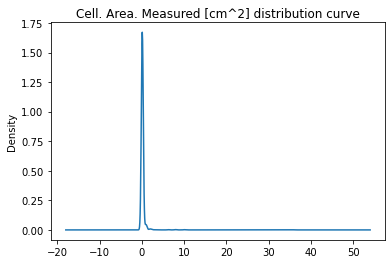

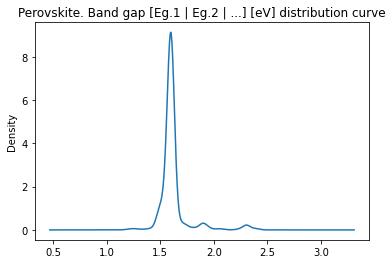

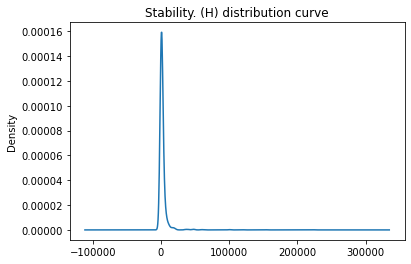

In [32]:
#visualize raw numerical data via distribution curve'
for col in valid_numerical_col:
    data_df[col].plot.kde()
    plt.title(f'{col} distribution curve')
    plt.show()

In [33]:
#normaiization target with ln(x + 1)
for col in valid_numerical_col:
    if col == 'Stability. (H)':
        data_df[f'{col} (Normailzed)'] = np.log(data_df[col] + 1)
        continue
    data_df[f'{col} (Normailzed)'] = data_df[col]
    print(f'{col} (Normailzed) \n')
    print(data_df[f'{col} (Normailzed)'].describe())
data_df.head(1000)

Cell. Area. Measured [cm^2] (Normailzed) 

count    1826.000000
mean        0.192979
std         1.011905
min         0.000200
25%         0.090000
50%         0.100000
75%         0.103750
max        36.000000
Name: Cell. Area. Measured [cm^2] (Normailzed), dtype: float64
Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV] (Normailzed) 

count    1826.000000
mean        1.622919
std         0.145508
min         1.180000
25%         1.600000
50%         1.600000
75%         1.600000
max         2.600000
Name: Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV] (Normailzed), dtype: float64


,Substrate,Electrode,Material,Electrode2,Cell. Architecture [nip/pin/ ?,Module [TRUE/FALSE],Cell. Area. Measured [cm^2],Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV],Stability. (H),Substrate Encode,Electrode Encode,Material Encode,Electrode2 Encode,Cell. Architecture [nip/pin/ ? Encode,Module [TRUE/FALSE] Encode,Cell. Area. Measured [cm^2] (Normailzed),Perovskite. Band gap [Eg.1 | Eg.2 | ...] [eV] (Normailzed),Stability. (H) (Normailzed)
0,SLG,FTO,Perovskite,Ag,pin,False,0.0900,1.55,168.304498,4,5,0,8,3,0,0.0900,1.55,5.131699
1,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,139.363154,4,7,0,8,3,0,0.0400,1.55,4.944233
2,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,140.048309,4,7,0,8,3,0,0.0400,1.55,4.949102
3,SLG,ITO,Perovskite,Ag,pin,False,0.0400,1.55,140.055821,4,7,0,8,3,0,0.0400,1.55,4.949156
4,SLG,ITO,Perovskite,Ag,pin,False,0.0919,1.27,2.500000,4,7,0,8,3,0,0.0919,1.27,1.252763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,SLG,FTO,Perovskite,Ag,pin,False,0.0900,1.60,1000.000000,4,5,0,8,3,0,0.0900,1.60,6.908755
996,SLG,ITO,Perovskite,Ag,pin,False,0.1200,1.60,1.944000,4,7,0,8,3,0,0.1200,1.60,1.079769
997,SLG,ITO,Perovskite,Ag,pin,False,0.1200,1.30,240.000000,4,7,0,8,3,0,0.1200,1.30,5.484797
998,PET,PEDOT:PSS,Perovskite,Ag,pin,True,3.2000,1.60,800.000000,2,3,0,8,3,1,3.2000,1.60,6.685861


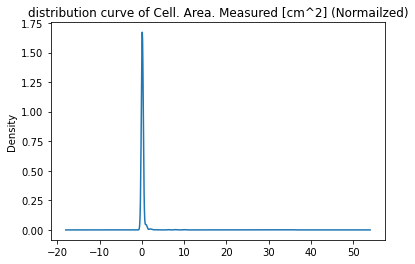

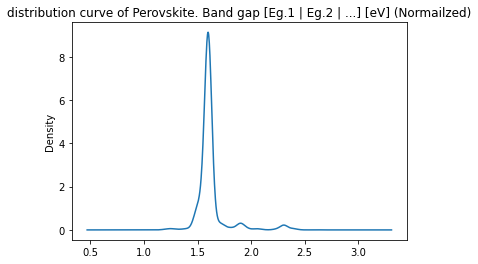

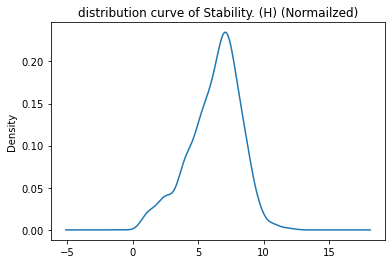

In [34]:
#visualize normalized numerical data via distribution curve'
for col in valid_numerical_col:
    new_col_name = f'{col} (Normailzed)'
    data_df[new_col_name].plot.kde()
    plt.title(f'distribution curve of {new_col_name}')
    plt.show()

In [35]:
#Neural Newtork Model

class NNregressor(nn.Module):
    def __init__(self, in_features, out_features):
        super(NNregressor, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.dense_layer_1 = nn.Sequential(
            nn.Linear(self.in_features, self.in_features*3),
            nn.BatchNorm1d(self.in_features*3),
            nn.LeakyReLU(0.3),
        )
        self.dense_layer_2 = nn.Sequential(
            nn.Linear(self.in_features*3, self.in_features*6),
            nn.BatchNorm1d(self.in_features*6),
            nn.LeakyReLU(0.3),
        )
        self.dense_layer_3 = nn.Sequential(
            nn.Linear(self.in_features*6, self.in_features*9),
            nn.BatchNorm1d(self.in_features*9),
            nn.LeakyReLU(0.3),
        )
        self.dense_layer_4 = nn.Sequential(
            nn.Linear(self.in_features*9, self.in_features*12),
            nn.BatchNorm1d(self.in_features*12),
            nn.LeakyReLU(0.3),
        )
        self.dense_layer_5 = nn.Sequential(
            nn.Linear(self.in_features*12, self.out_features),
        )
        self.dropout_layer = nn.Dropout(0.2)

        
    def forward(self, feature):
        output = self.dense_layer_1(feature)
        output = self.dense_layer_2(output)
        output = self.dense_layer_3(output)
        output = self.dense_layer_4(output)
        output = self.dense_layer_5(output)
        #output = self.dropout_layer(output)
        return output


In [36]:
#select feature and target columns to train with
feature_label = []
target_label = ['Stability. (H) (Normailzed)']
for col in valid_categorical_col:
    feature_label.append(f'{col} Encode')
for col in valid_numerical_col:
    if col == 'Stability. (H) (Normailzed)':
        continue
    feature_label.append(f'{col} (Normailzed)')

feature_data = data_df[feature_label].to_numpy().reshape(-1, len(feature_label))
target_data = data_df[target_label].to_numpy().reshape(-1, 1)

print(f'feature data size: {feature_data.shape}')
print(f'Target data size: {target_data.shape}')
data_df[target_label].head()

feature data size: (1826, 9)
Target data size: (1826, 1)


,Stability. (H) (Normailzed)
0,5.131699
1,4.944233
2,4.949102
3,4.949156
4,1.252763


In [37]:
#hyper-param
in_features = len(feature_label)
out_features = len(target_label)
test_size = 0.1
lr = 1e-3
epochs = 200
train_batch_size = 600

#set model
regression_model = NNregressor(in_features, out_features)
lossFunc = nn.MSELoss()
optimizer = optim.Adam(regression_model.parameters(), lr=lr)

#data_splice
def splice(X, y, test_size=test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#numpy to tensor
def numpy_to_tensor(*array):
    tensor = tuple(torch.Tensor(i) for i in array)
    return tensor

X_train, X_test, y_train, y_test = splice(feature_data, target_data)
X_train, X_test, y_train, y_test = numpy_to_tensor(X_train, X_test, y_train, y_test)



In [38]:
#Compute R2Score
def R2Score(actual, pred):
    #convert the tensor parameters to numpy array and detach the gradient from pred
    actual, pred = actual.numpy(), pred.detach().numpy()
    actual, pred = actual.reshape(-1), pred.reshape(-1)
    numerator = np.sum(np.square(actual - pred))
    denominator = np.sum(np.square(actual - np.mean(actual)))
    return 1 - (numerator/denominator)

In [39]:
#training process
def training_process(X, y, epochs, batch_size):
    total_loss = list()
    total_R2Score = list()
    for epoch in range(epochs):
        print(f'Epoch no: {epoch+1}')
        batch_loss = list()
        batch_R2Score = list()
        regression_model.train()
        for idx in tqdm(range(0, len(X), batch_size)):
            optimizer.zero_grad()
            X_batch = X[idx:idx+batch_size]
            y_batch = y[idx:idx+batch_size]
            pred = regression_model(X_batch)
            loss = torch.sqrt(lossFunc(pred, y_batch))
            train_R2score = R2Score(y_batch, pred)
            batch_R2Score.append(train_R2score)
            batch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        mean_batch_loss, mean_batch_R2Score = np.mean(batch_loss), np.mean(batch_R2Score)
        print(f'RMSE batch_loss is: {mean_batch_loss} \n R^2 Score: {mean_batch_R2Score}')
        total_loss.append(mean_batch_loss)
        total_R2Score.append(mean_batch_R2Score)

training_process(X_train, y_train, epochs=epochs, batch_size=train_batch_size)


100%|██████████| 3/3 [00:00<00:00, 48.64it/s]

Epoch no: 1



100%|██████████| 3/3 [00:00<00:00, 57.72it/s]

RMSE batch_loss is: 6.375411510467529 
 R^2 Score: -9.553560256958008
Epoch no: 2
RMSE batch_loss is: 6.087473074595134 
 R^2 Score: -8.623977979024252
Epoch no: 3



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 5.908154169718425 
 R^2 Score: -8.066566467285156
Epoch no: 4
RMSE batch_loss is: 5.761171976725261 
 R^2 Score: -7.621408144632976
Epoch no: 5


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 5.620443344116211 
 R^2 Score: -7.205524444580078
Epoch no: 6
RMSE batch_loss is: 5.480673789978027 
 R^2 Score: -6.802610397338867
Epoch no: 7


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 5.3422519365946455 
 R^2 Score: -6.413509368896484
Epoch no: 8
RMSE batch_loss is: 5.20459779103597 
 R^2 Score: -6.036491235097249
Epoch no: 9


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 5.069486300150554 
 R^2 Score: -5.676070690155029
Epoch no: 10
RMSE batch_loss is: 4.936881224314372 
 R^2 Score: -5.331465403238933
Epoch no: 11


100%|██████████| 3/3 [00:00<00:00, 46.88it/s]

RMSE batch_loss is: 4.806587378184001 
 R^2 Score: -5.001758098602295
Epoch no: 12



100%|██████████| 3/3 [00:00<00:00, 64.85it/s]

RMSE batch_loss is: 4.676700115203857 
 R^2 Score: -4.681873003641765
Epoch no: 13
RMSE batch_loss is: 4.54626448949178 
 R^2 Score: -4.3695095380147295
Epoch no: 14



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 4.416140715281169 
 R^2 Score: -4.0667374928792315
Epoch no: 15
RMSE batch_loss is: 4.285646279652913 
 R^2 Score: -3.771878401438395
Epoch no: 16


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 4.153498649597168 
 R^2 Score: -3.482227325439453
Epoch no: 17
RMSE batch_loss is: 4.019505739212036 
 R^2 Score: -3.1977694034576416
Epoch no: 18


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 3.8840417861938477 
 R^2 Score: -2.9196813106536865
Epoch no: 19
RMSE batch_loss is: 3.746328592300415 
 R^2 Score: -2.64675235748291
Epoch no: 20


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 3.606197992960612 
 R^2 Score: -2.3791240056355796
Epoch no: 21
RMSE batch_loss is: 3.4637295405069985 
 R^2 Score: -2.1174776554107666
Epoch no: 22


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 3.318634271621704 
 R^2 Score: -1.8618655999501545
Epoch no: 23
RMSE batch_loss is: 3.1700805028279624 
 R^2 Score: -1.6114807923634846
Epoch no: 24


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 3.0175060431162515 
 R^2 Score: -1.3662420908610027
Epoch no: 25
RMSE batch_loss is: 2.8606894810994468 
 R^2 Score: -1.12679918607076
Epoch no: 26


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 2.7001158396402993 
 R^2 Score: -0.8948659499486288
Epoch no: 27
RMSE batch_loss is: 2.536026875178019 
 R^2 Score: -0.6716870864232382
Epoch no: 28


100%|██████████| 3/3 [00:00<00:00, 53.57it/s]

RMSE batch_loss is: 2.3682175477345786 
 R^2 Score: -0.4579209089279175
Epoch no: 29



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 2.1967612902323403 
 R^2 Score: -0.2546190023422241
Epoch no: 30
RMSE batch_loss is: 2.0214723348617554 
 R^2 Score: -0.06256606181462605
Epoch no: 31
RMSE batch_loss is: 1.842140555381775 
 R^2 Score: 0.11740861336390178
Epoch no: 32


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 1.6583682298660278 
 R^2 Score: 0.2845420241355896
Epoch no: 33


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 1.4704569180806477 
 R^2 Score: 0.43730223178863525
Epoch no: 34
RMSE batch_loss is: 1.2790806293487549 
 R^2 Score: 0.5740461548169454
Epoch no: 35
RMSE batch_loss is: 1.0852194627126057 
 R^2 Score: 0.6931710044542948
Epoch no: 36


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.8903523484865824 
 R^2 Score: 0.7932997047901154
Epoch no: 37


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.6943681637446085 
 R^2 Score: 0.8739746113618215
Epoch no: 38
RMSE batch_loss is: 0.5260279377301534 
 R^2 Score: 0.9281689152121544
Epoch no: 39
RMSE batch_loss is: 0.40369977553685504 
 R^2 Score: 0.9567782897502184
Epoch no: 40


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.3524034569660823 
 R^2 Score: 0.9646708220243454
Epoch no: 41
RMSE batch_loss is: 0.2857403556505839 
 R^2 Score: 0.9785963967442513
Epoch no: 42
RMSE batch_loss is: 0.28520522514979046 
 R^2 Score: 0.9786841521660486
Epoch no: 43
RMSE batch_loss is: 0.2519331177075704 
 R^2 Score: 0.9826885764487088
Epoch no: 44


100%|██████████| 3/3 [00:00<00:00, 46.87it/s]

RMSE batch_loss is: 0.21437973777453104 
 R^2 Score: 0.9876843392848969
Epoch no: 45
RMSE batch_loss is: 0.19382483263810477 
 R^2 Score: 0.9899708842858672
Epoch no: 46
RMSE batch_loss is: 0.1569443941116333 
 R^2 Score: 0.9935051654465497
Epoch no: 47



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.1593396763006846 
 R^2 Score: 0.9932828368619084
Epoch no: 48
RMSE batch_loss is: 0.14488992591698965 
 R^2 Score: 0.9944236087612808
Epoch no: 49
RMSE batch_loss is: 0.13367379953463873 
 R^2 Score: 0.9953033795269827
Epoch no: 50
RMSE batch_loss is: 0.1248295654853185 
 R^2 Score: 0.9959539365954697
Epoch no: 51


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.13688070823748907 
 R^2 Score: 0.995003680465743
Epoch no: 52
RMSE batch_loss is: 0.14079576482375464 
 R^2 Score: 0.9946299083530903
Epoch no: 53
RMSE batch_loss is: 0.14571115374565125 
 R^2 Score: 0.9943450734329721
Epoch no: 54
RMSE batch_loss is: 0.14050340900818506 
 R^2 Score: 0.9945885521204522
Epoch no: 55


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.14694119493166605 
 R^2 Score: 0.9942496828734875
Epoch no: 56
RMSE batch_loss is: 0.13451015700896582 
 R^2 Score: 0.9952640034413586
Epoch no: 57
RMSE batch_loss is: 0.11512501537799835 
 R^2 Score: 0.9965448473424962
Epoch no: 58


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.09861359496911366 
 R^2 Score: 0.9974221986485645
Epoch no: 59
RMSE batch_loss is: 0.09224616487820943 
 R^2 Score: 0.9976888387075936
Epoch no: 60
RMSE batch_loss is: 0.09710725396871567 
 R^2 Score: 0.9974856114713475
Epoch no: 61


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.09447116156419118 
 R^2 Score: 0.9976262999310469
Epoch no: 62
RMSE batch_loss is: 0.10796929647525151 
 R^2 Score: 0.9966913737977544
Epoch no: 63
RMSE batch_loss is: 0.12312868237495422 
 R^2 Score: 0.9960037114409109
Epoch no: 64


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.10361827909946442 
 R^2 Score: 0.9971693037853887
Epoch no: 65
RMSE batch_loss is: 0.1136699691414833 
 R^2 Score: 0.9966024002060294
Epoch no: 66


100%|██████████| 3/3 [00:00<00:00, 31.25it/s]

RMSE batch_loss is: 0.1014506568511327 
 R^2 Score: 0.9973322198881457
Epoch no: 67
RMSE batch_loss is: 0.10100146879752477 
 R^2 Score: 0.9973497242511561
Epoch no: 68



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.09578088174263637 
 R^2 Score: 0.9976167494120697
Epoch no: 69
RMSE batch_loss is: 0.08984760691722234 
 R^2 Score: 0.997891632335571
Epoch no: 70
RMSE batch_loss is: 0.09781134128570557 
 R^2 Score: 0.9974948967574164
Epoch no: 71


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.08926587055126826 
 R^2 Score: 0.9979252334839354
Epoch no: 72
RMSE batch_loss is: 0.089705025156339 
 R^2 Score: 0.997901577463684
Epoch no: 73
RMSE batch_loss is: 0.0943930521607399 
 R^2 Score: 0.9976852658825616
Epoch no: 74


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.08560321728388469 
 R^2 Score: 0.9980984950282922
Epoch no: 75
RMSE batch_loss is: 0.08593465636173885 
 R^2 Score: 0.998085175951322
Epoch no: 76
RMSE batch_loss is: 0.08430260419845581 
 R^2 Score: 0.9981549277047937
Epoch no: 77


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.08061433583498001 
 R^2 Score: 0.9983135484702265
Epoch no: 78
RMSE batch_loss is: 0.08132980515559514 
 R^2 Score: 0.9982829911556715
Epoch no: 79
RMSE batch_loss is: 0.08045263836781184 
 R^2 Score: 0.9983221530371035
Epoch no: 80


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.07912339270114899 
 R^2 Score: 0.9983753910055384
Epoch no: 81
RMSE batch_loss is: 0.07985070099433263 
 R^2 Score: 0.9983457035850734
Epoch no: 82
RMSE batch_loss is: 0.08717295279105504 
 R^2 Score: 0.9980219705418373
Epoch no: 83


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.08264698336521785 
 R^2 Score: 0.9981875912441561
Epoch no: 84
RMSE batch_loss is: 0.09716310352087021 
 R^2 Score: 0.9975068198594575
Epoch no: 85
RMSE batch_loss is: 0.08158083632588387 
 R^2 Score: 0.9982106502284296
Epoch no: 86


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.07333376258611679 
 R^2 Score: 0.9985764964561289
Epoch no: 87
RMSE batch_loss is: 0.08515873303016026 
 R^2 Score: 0.9981154039269313
Epoch no: 88
RMSE batch_loss is: 0.0782726729909579 
 R^2 Score: 0.998405113001354
Epoch no: 89


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.07067705442508061 
 R^2 Score: 0.998654574873702
Epoch no: 90
RMSE batch_loss is: 0.07313110679388046 
 R^2 Score: 0.9986101442870373
Epoch no: 91
RMSE batch_loss is: 0.08033941686153412 
 R^2 Score: 0.9982857709983364
Epoch no: 92


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.07087174554665883 
 R^2 Score: 0.998688129746976
Epoch no: 93
RMSE batch_loss is: 0.07010106494029363 
 R^2 Score: 0.9987188045245906
Epoch no: 94
RMSE batch_loss is: 0.06622633462150891 
 R^2 Score: 0.9988587889432287
Epoch no: 95


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.07184545695781708 
 R^2 Score: 0.9986319952877238
Epoch no: 96
RMSE batch_loss is: 0.07145007451375325 
 R^2 Score: 0.9986727974222352
Epoch no: 97
RMSE batch_loss is: 0.0667996530731519 
 R^2 Score: 0.9988418344485884
Epoch no: 98


100%|██████████| 3/3 [00:00<00:00, 37.50it/s]

RMSE batch_loss is: 0.06375521421432495 
 R^2 Score: 0.9989311138439613
Epoch no: 99
RMSE batch_loss is: 0.07170123606920242 
 R^2 Score: 0.9986340224665279
Epoch no: 100



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.0782521516084671 
 R^2 Score: 0.9984049891742567
Epoch no: 101
RMSE batch_loss is: 0.07708446184794109 
 R^2 Score: 0.9984030981043664
Epoch no: 102
RMSE batch_loss is: 0.07134979590773582 
 R^2 Score: 0.9986593730088013
Epoch no: 103


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.07329890877008438 
 R^2 Score: 0.9985962539212778
Epoch no: 104
RMSE batch_loss is: 0.06467869381109874 
 R^2 Score: 0.9989004794236583
Epoch no: 105


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05927653362353643 
 R^2 Score: 0.999089097584753
Epoch no: 106
RMSE batch_loss is: 0.06509884695212047 
 R^2 Score: 0.9988872260825398
Epoch no: 107
RMSE batch_loss is: 0.06069304173191389 
 R^2 Score: 0.9990332607994787
Epoch no: 108


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.06755274410049121 
 R^2 Score: 0.9987696008368706
Epoch no: 109
RMSE batch_loss is: 0.06665979574124019 
 R^2 Score: 0.9988310962604979
Epoch no: 110
RMSE batch_loss is: 0.06853566194574039 
 R^2 Score: 0.9987797936191782
Epoch no: 111


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.062065038830041885 
 R^2 Score: 0.9989798226937031
Epoch no: 112
RMSE batch_loss is: 0.05376569554209709 
 R^2 Score: 0.9992498670665858
Epoch no: 113
RMSE batch_loss is: 0.06501616289218266 
 R^2 Score: 0.998891624272801
Epoch no: 114


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.061807687083880104 
 R^2 Score: 0.9989581614305886
Epoch no: 115
RMSE batch_loss is: 0.06927350411812465 
 R^2 Score: 0.9987533205033591
Epoch no: 116
RMSE batch_loss is: 0.06744982798894246 
 R^2 Score: 0.9987979398768706
Epoch no: 117


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.06340625633796056 
 R^2 Score: 0.9989185910089873
Epoch no: 118
RMSE batch_loss is: 0.05957190195719401 
 R^2 Score: 0.9990795397704156
Epoch no: 119
RMSE batch_loss is: 0.06722218170762062 
 R^2 Score: 0.9987452289788052
Epoch no: 120


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.06381163249413173 
 R^2 Score: 0.9989409617458781
Epoch no: 121
RMSE batch_loss is: 0.06434885660807292 
 R^2 Score: 0.9989118781716874
Epoch no: 122
RMSE batch_loss is: 0.06061481684446335 
 R^2 Score: 0.9990426698544373
Epoch no: 123


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.06446951255202293 
 R^2 Score: 0.998921766198085
Epoch no: 124
RMSE batch_loss is: 0.07045602798461914 
 R^2 Score: 0.9987076156151792
Epoch no: 125
RMSE batch_loss is: 0.06022697066267332 
 R^2 Score: 0.9990547352742093
Epoch no: 126


100%|██████████| 3/3 [00:00<00:00, 40.33it/s]


RMSE batch_loss is: 0.06002615888913473 
 R^2 Score: 0.9990606089122593
Epoch no: 127
RMSE batch_loss is: 0.059012035528818764 
 R^2 Score: 0.9990958743728697
Epoch no: 128
RMSE batch_loss is: 0.06153339147567749 
 R^2 Score: 0.9990171986282803
Epoch no: 129


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.061762926479180656 
 R^2 Score: 0.9990075206927335
Epoch no: 130
RMSE batch_loss is: 0.057172408948342 
 R^2 Score: 0.9991498846793547
Epoch no: 131
RMSE batch_loss is: 0.06234158327182134 
 R^2 Score: 0.9989901696098968
Epoch no: 132


100%|██████████| 3/3 [00:00<00:00, 28.85it/s]

RMSE batch_loss is: 0.05753380556901296 
 R^2 Score: 0.999141596199479
Epoch no: 133
RMSE batch_loss is: 0.06031494587659836 
 R^2 Score: 0.9990368114085868
Epoch no: 134


100%|██████████| 3/3 [00:00<00:00, 34.02it/s]

RMSE batch_loss is: 0.05433687443534533 
 R^2 Score: 0.9992294765543193
Epoch no: 135
RMSE batch_loss is: 0.055467722316583 
 R^2 Score: 0.999187676430059
Epoch no: 136



100%|██████████| 3/3 [00:00<00:00, 39.53it/s]


RMSE batch_loss is: 0.060228134195009865 
 R^2 Score: 0.9990411941932203
Epoch no: 137
RMSE batch_loss is: 0.062012773007154465 
 R^2 Score: 0.9989892086402202
Epoch no: 138


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.057500420759121575 
 R^2 Score: 0.9991334912677606
Epoch no: 139
RMSE batch_loss is: 0.06165911629796028 
 R^2 Score: 0.9989907865722975
Epoch no: 140
RMSE batch_loss is: 0.05786689122517904 
 R^2 Score: 0.999118902933939
Epoch no: 141


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05536313106616338 
 R^2 Score: 0.9991877595505988
Epoch no: 142
RMSE batch_loss is: 0.055002657075723015 
 R^2 Score: 0.9992102509519706
Epoch no: 143
RMSE batch_loss is: 0.06065542623400688 
 R^2 Score: 0.9990168317065885
Epoch no: 144


100%|██████████| 3/3 [00:00<00:00, 37.50it/s]

RMSE batch_loss is: 0.05648095409075419 
 R^2 Score: 0.999115457709801
Epoch no: 145
RMSE batch_loss is: 0.04881059378385544 
 R^2 Score: 0.9993603579932824
Epoch no: 146



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.050155024975538254 
 R^2 Score: 0.9993457912739055
Epoch no: 147
RMSE batch_loss is: 0.05918776740630468 
 R^2 Score: 0.9990594332533268
Epoch no: 148
RMSE batch_loss is: 0.05956894780198733 
 R^2 Score: 0.999063519120682
Epoch no: 149


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05282233655452728 
 R^2 Score: 0.9992725252523087
Epoch no: 150
RMSE batch_loss is: 0.05037546157836914 
 R^2 Score: 0.9993275160183354
Epoch no: 151
RMSE batch_loss is: 0.05276627838611603 
 R^2 Score: 0.9992673950619064
Epoch no: 152


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05813931549588839 
 R^2 Score: 0.9991232415001529
Epoch no: 153
RMSE batch_loss is: 0.056043763955434166 
 R^2 Score: 0.9991680960714197
Epoch no: 154
RMSE batch_loss is: 0.05105271438757578 
 R^2 Score: 0.999302637540192
Epoch no: 155


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05291890352964401 
 R^2 Score: 0.9992721172554108
Epoch no: 156
RMSE batch_loss is: 0.05436967313289642 
 R^2 Score: 0.9991976993721133
Epoch no: 157
RMSE batch_loss is: 0.0649714469909668 
 R^2 Score: 0.9988968747396333
Epoch no: 158


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.06482058266798656 
 R^2 Score: 0.9988730630720966
Epoch no: 159
RMSE batch_loss is: 0.04554653416077296 
 R^2 Score: 0.999445683992235
Epoch no: 160
RMSE batch_loss is: 0.0498922032614549 
 R^2 Score: 0.9993373280352292
Epoch no: 161


100%|██████████| 3/3 [00:00<00:00, 46.88it/s]

RMSE batch_loss is: 0.054403344790140785 
 R^2 Score: 0.9992275061667897
Epoch no: 162
RMSE batch_loss is: 0.05586992452541987 
 R^2 Score: 0.9991554802982137
Epoch no: 163
RMSE batch_loss is: 0.053286818166573845 
 R^2 Score: 0.9992491659359075
Epoch no: 164



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.04656348998347918 
 R^2 Score: 0.9993942222160209
Epoch no: 165
RMSE batch_loss is: 0.04816051200032234 
 R^2 Score: 0.9993891822135387
Epoch no: 166


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.055027288695176445 
 R^2 Score: 0.9991724916811412
Epoch no: 167
RMSE batch_loss is: 0.05532298485438029 
 R^2 Score: 0.9991910167348882
Epoch no: 168
RMSE batch_loss is: 0.045854988197485604 
 R^2 Score: 0.9994421160275427
Epoch no: 169


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.049303676933050156 
 R^2 Score: 0.9993484306129782
Epoch no: 170
RMSE batch_loss is: 0.05006996418039004 
 R^2 Score: 0.9993438711583925
Epoch no: 171
RMSE batch_loss is: 0.053372775514920555 
 R^2 Score: 0.9992614189977758
Epoch no: 172


100%|██████████| 3/3 [00:00<00:00, 46.88it/s]

RMSE batch_loss is: 0.05034523829817772 
 R^2 Score: 0.9993237804543847
Epoch no: 173
RMSE batch_loss is: 0.048592558751503624 
 R^2 Score: 0.9993867913144641
Epoch no: 174
RMSE batch_loss is: 0.05964044854044914 
 R^2 Score: 0.9989827028572714
Epoch no: 175



  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05207019050916036 
 R^2 Score: 0.9992375431659942
Epoch no: 176
RMSE batch_loss is: 0.0448906309902668 
 R^2 Score: 0.9994705601905783
Epoch no: 177
RMSE batch_loss is: 0.04878809303045273 
 R^2 Score: 0.9993457402839946
Epoch no: 178


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05182220786809921 
 R^2 Score: 0.9993013089212278
Epoch no: 179
RMSE batch_loss is: 0.05572374413410822 
 R^2 Score: 0.9991801172727719
Epoch no: 180
RMSE batch_loss is: 0.04956338678797086 
 R^2 Score: 0.9993599909551752
Epoch no: 181


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05176344638069471 
 R^2 Score: 0.9992954211581188
Epoch no: 182
RMSE batch_loss is: 0.047614232947429024 
 R^2 Score: 0.9993985772792561
Epoch no: 183
RMSE batch_loss is: 0.05572114263971647 
 R^2 Score: 0.999168091599131
Epoch no: 184


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.04946776106953621 
 R^2 Score: 0.9993548602603065
Epoch no: 185
RMSE batch_loss is: 0.04705266530315081 
 R^2 Score: 0.9994015216846796
Epoch no: 186
RMSE batch_loss is: 0.049904423455397286 
 R^2 Score: 0.9993477194026733
Epoch no: 187


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05430765450000763 
 R^2 Score: 0.9992316934900979
Epoch no: 188
RMSE batch_loss is: 0.04157714173197746 
 R^2 Score: 0.9995406526916971
Epoch no: 189
RMSE batch_loss is: 0.04105323553085327 
 R^2 Score: 0.999554636500155
Epoch no: 190


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05068952217698097 
 R^2 Score: 0.9993263013311662
Epoch no: 191
RMSE batch_loss is: 0.05197226877013842 
 R^2 Score: 0.9992979478750689
Epoch no: 192
RMSE batch_loss is: 0.040358208740750946 
 R^2 Score: 0.9995379920340687
Epoch no: 193


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.0346444807946682 
 R^2 Score: 0.9996860934285602
Epoch no: 194
RMSE batch_loss is: 0.030774482215444248 
 R^2 Score: 0.9997514321536679
Epoch no: 195
RMSE batch_loss is: 0.05333752681811651 
 R^2 Score: 0.9992500276227171
Epoch no: 196


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE batch_loss is: 0.05933992067972819 
 R^2 Score: 0.9990300102023563
Epoch no: 197
RMSE batch_loss is: 0.04743107035756111 
 R^2 Score: 0.9993938210439713
Epoch no: 198
RMSE batch_loss is: 0.05016842857003212 
 R^2 Score: 0.9993340957153123
Epoch no: 199


100%|██████████| 3/3 [00:00<00:00, 37.50it/s]

RMSE batch_loss is: 0.038832008838653564 
 R^2 Score: 0.9996053337041909
Epoch no: 200
RMSE batch_loss is: 0.04427429288625717 
 R^2 Score: 0.9994910240833027


RMSE: 0.08570294827222824 
 R^2 Score: 0.9978519091382623


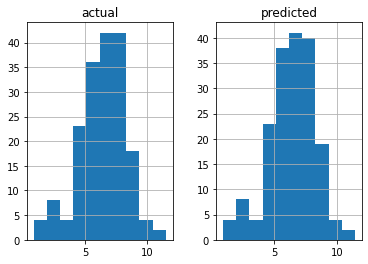

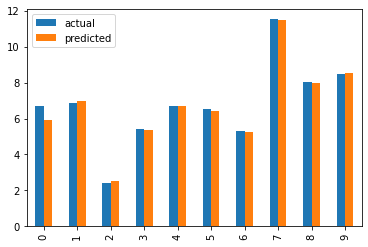

In [40]:
#testing process

def inference(X, y):
    comparison_df = pd.DataFrame()
    comparison_df['actual'] = np.array(y).reshape(-1)
    regression_model.eval()
    with torch.no_grad():
        pred = regression_model(X)
        comparison_df['predicted'] = np.array(pred.detach()).reshape(-1)
        RMSE_loss = torch.sqrt(lossFunc(pred, y))
        test_R2Score = R2Score(y, pred)
        print(f'RMSE: {RMSE_loss} \n R^2 Score: {test_R2Score}')

    #plot histogram of comparison
    comparison_df.hist()

    #plot bar chart of comparison
    comparison_df.head(10).plot.bar()
inference(X_test, y_test)